In [1]:
from utils.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, normalize
from config.dataset import get_dataset_path


In [2]:
NUM_SEGMENTS = 1
FRAMES_PER_SEGMENT = 12
BATCH_SIZE = 2
IMAGE_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.01


In [3]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos")
multiple_transform = get_transform(IMAGE_SIZE)


In [4]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
classes


['before',
 'book',
 'candy',
 'chair',
 'clothes',
 'computer',
 'cousin',
 'drink',
 'go',
 'who']

In [5]:
from utils.loader import split_dataset


In [6]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.7, validation_split=0.1, batch_size=BATCH_SIZE
)


In [7]:
print(len(train_loader), len(validation_loader), len(test_loader))


98 14 29


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [8]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [9]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, norm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = normalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

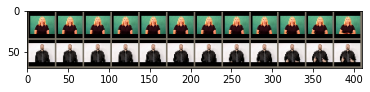

In [10]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 16, 2, 16, 16])
torch.Size([2, 32, 1, 8, 8])


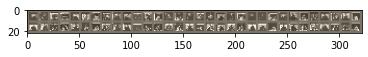

In [11]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=(2, 3, 3), stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [12]:
# from utils.balance import check_balance_status

# check_balance_status(test_loader, classes)
# check_balance_status(train_loader, classes)


In [13]:
# from lib.model import resnet34 as resnet

# model = resnet(sample_duration=FRAMES_PER_SEGMENT*NUM_SEGMENTS, sample_size=IMAGE_SIZE, num_classes=len(classes))
# model


In [14]:
from lib.simple_model import HPNet, CNNNet

Net = HPNet  # HPNet

model = Net(
    num_classes=len(classes),
    batch_size=BATCH_SIZE,
    num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    image_size=IMAGE_SIZE,
    debug=False,
)

model


HPNet(
  (conv3d_1): Sequential(
    (0): Conv3d(12, 32, kernel_size=(2, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (batch_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (batch_2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin_1): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (lin_2): Sequential(
    (0): Linear(in_features=2048, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (soft): LogSoftmax(dim=1)
  (drop): Dropout(p=0.15, inplace=False)
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [15]:
from lib.train import train_model


In [16]:
train_costs, val_costs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Train cost at epoch 1 is 2.31362
Validation cost at epoch 1 is 2.30906
Train cost at epoch 2 is 2.26334
Validation cost at epoch 2 is 2.31046
Train cost at epoch 3 is 2.27139
Validation cost at epoch 3 is 2.32329
Train cost at epoch 4 is 2.19465
Validation cost at epoch 4 is 2.31901
Train cost at epoch 5 is 2.03701
Validation cost at epoch 5 is 2.41669
Train cost at epoch 6 is 1.80133
Validation cost at epoch 6 is 2.35095
Train cost at epoch 7 is 1.61627
Validation cost at epoch 7 is 2.44083
Train cost at epoch 8 is 1.32881
Validation cost at epoch 8 is 2.99254
Train cost at epoch 9 is 1.08477
Validation cost at epoch 9 is 2.88803
Train cost at epoch 10 is 0.85866
Validation cost at epoch 10 is 3.33097
Train cost at epoch 11 is 0.74127
Validation cost at epoch 11 is 2.93322
Train cost at epoch 12 is 0.60069
Validation cost at epoch 12 is 2.88333
Train cost at epoch 13 is 0.39954
Validation cost at epoch 13 is 3.29914
Train cost at epoch 14 is 0.24356
Validation

### Normalize costs between 0 and 1

In [17]:
from utils.output import plot_costs

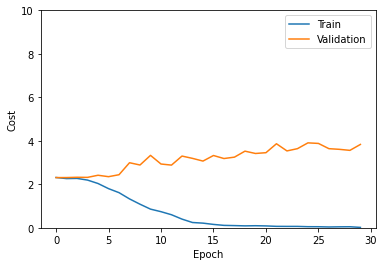

<Figure size 72x72 with 0 Axes>

In [18]:
plot_costs(train_costs, val_costs)


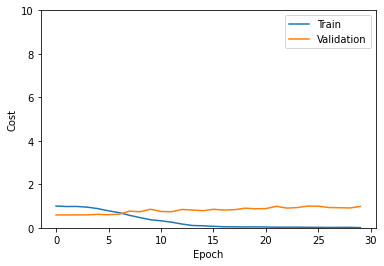

<Figure size 72x72 with 0 Axes>

In [19]:
# Normalized costs. Does not represent real cost values.
plot_costs(train_costs, val_costs, normalize_data=True)


In [20]:
from lib.test import check_accuracy


In [21]:
check_accuracy(train_loader, model, classes, device, n_batchs=10)


Predictions for batch 1 
['cousin', 'drink']
Ground truth for batch 1
['cousin', 'drink']
---------------------------------


Predictions for batch 2 
['candy', 'book']
Ground truth for batch 2
['candy', 'book']
---------------------------------


Predictions for batch 3 
['candy', 'book']
Ground truth for batch 3
['candy', 'book']
---------------------------------


Predictions for batch 4 
['computer', 'chair']
Ground truth for batch 4
['computer', 'chair']
---------------------------------


Predictions for batch 5 
['go', 'book']
Ground truth for batch 5
['go', 'book']
---------------------------------


Predictions for batch 6 
['go', 'chair']
Ground truth for batch 6
['go', 'chair']
---------------------------------


Predictions for batch 7 
['drink', 'cousin']
Ground truth for batch 7
['drink', 'cousin']
---------------------------------


Predictions for batch 8 
['drink', 'clothes']
Ground truth for batch 8
['drink', 'clothes']
---------------------------------


Predictions 

In [22]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['book', 'cousin']
Ground truth for batch 1
['book', 'cousin']
---------------------------------


Predictions for batch 2 
['before', 'drink']
Ground truth for batch 2
['drink', 'who']
---------------------------------


Predictions for batch 3 
['candy', 'drink']
Ground truth for batch 3
['drink', 'book']
---------------------------------


Predictions for batch 4 
['computer', 'before']
Ground truth for batch 4
['computer', 'who']
---------------------------------


Predictions for batch 5 
['book', 'book']
Ground truth for batch 5
['book', 'book']
---------------------------------


Predictions for batch 6 
['book', 'candy']
Ground truth for batch 6
['book', 'candy']
---------------------------------


Predictions for batch 7 
['chair', 'book']
Ground truth for batch 7
['clothes', 'book']
---------------------------------


Predictions for batch 8 
['chair', 'before']
Ground truth for batch 8
['go', 'who']
---------------------------------


Predictions for

In [23]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['clothes', 'computer']
Ground truth for batch 1
['chair', 'chair']
---------------------------------


Predictions for batch 2 
['clothes', 'candy']
Ground truth for batch 2
['before', 'chair']
---------------------------------


Predictions for batch 3 
['go', 'before']
Ground truth for batch 3
['go', 'computer']
---------------------------------


Predictions for batch 4 
['who', 'book']
Ground truth for batch 4
['candy', 'book']
---------------------------------


Predictions for batch 5 
['drink', 'chair']
Ground truth for batch 5
['candy', 'clothes']
---------------------------------


Predictions for batch 6 
['before', 'cousin']
Ground truth for batch 6
['go', 'before']
---------------------------------


Predictions for batch 7 
['before', 'who']
Ground truth for batch 7
['computer', 'candy']
---------------------------------


Predictions for batch 8 
['chair', 'book']
Ground truth for batch 8
['chair', 'computer']
---------------------------------


